贝叶斯网络之算法实现
===

# 1.对鸢尾花数据进行分类

训练集准确度: 82.86%
测试集准确度：71.11%


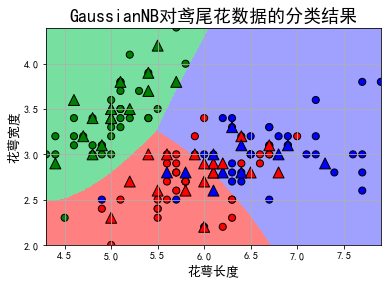

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import os

data_path = os.path.join("../../data")

def iris_type(s):
    it = {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}
    return it[s]

data = pd.read_csv(os.path.join(data_path, 'iris.data'), header=None)
x, y = data[np.arange(4)], data[4]
y = pd.Categorical(values=y).codes
feature_names = u'花萼长度', u'花萼宽度', u'花瓣长度', u'花瓣宽度'
features = [0,1]
x = x[features]
x, x_test, y, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

priors = np.array((1,2,4), dtype=float)
priors /= priors.sum()
gnb = Pipeline([
    ('sc', StandardScaler()),
    ('poly', PolynomialFeatures(degree=1)), # 扩展成向量
    ('clf', GaussianNB(priors=priors))])    # 由于鸢尾花数据是样本均衡的，其实不需要设置先验值
gnb.fit(x, y.ravel())
y_hat = gnb.predict(x)
print('训练集准确度: %.2f%%' % (100 * accuracy_score(y, y_hat)))
y_test_hat = gnb.predict(x_test)
print('测试集准确度：%.2f%%' % (100 * accuracy_score(y_test, y_test_hat)))  # 画图

N, M = 500, 500     # 横纵各采样多少个值
x1_min, x2_min = x.min()
x1_max, x2_max = x.max()
t1 = np.linspace(x1_min, x1_max, N)
t2 = np.linspace(x2_min, x2_max, M)
x1, x2 = np.meshgrid(t1, t2)                    # 生成网格采样点
x_grid = np.stack((x1.flat, x2.flat), axis=1)   # 测试点

mpl.rcParams['font.sans-serif'] = [u'simHei']
mpl.rcParams['axes.unicode_minus'] = False
cm_light = mpl.colors.ListedColormap(['#77E0A0', '#FF8080', '#A0A0FF'])
cm_dark = mpl.colors.ListedColormap(['g', 'r', 'b'])
y_grid_hat = gnb.predict(x_grid)                  # 预测值
y_grid_hat = y_grid_hat.reshape(x1.shape)
plt.figure(facecolor='w')
plt.pcolormesh(x1, x2, y_grid_hat, cmap=cm_light)     # 预测值的显示
plt.scatter(x[features[0]], x[features[1]], c=y, edgecolors='k', s=50, cmap=cm_dark)
plt.scatter(x_test[features[0]], x_test[features[1]], c=y_test, marker='^', edgecolors='k', s=120, cmap=cm_dark)

plt.xlabel(feature_names[features[0]], fontsize=13)
plt.ylabel(feature_names[features[1]], fontsize=13)
plt.xlim(x1_min, x1_max)
plt.ylim(x2_min, x2_max)
plt.title(u'GaussianNB对鸢尾花数据的分类结果', fontsize=18)
plt.grid(True)

# 2.对新闻数据进行分类

In [2]:
import numpy as np
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from time import time
from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib as mpl

def test_clf(clf):
    print(u'分类器：', clf)
    alpha_can = np.logspace(-3, 2, 10)
    model = GridSearchCV(clf, param_grid={'alpha': alpha_can}, cv=5)
    m = alpha_can.size
    if hasattr(clf, 'alpha'):
        model.set_params(param_grid={'alpha': alpha_can})
        m = alpha_can.size
    if hasattr(clf, 'n_neighbors'):
        neighbors_can = np.arange(1, 15)
        model.set_params(param_grid={'n_neighbors': neighbors_can})
        m = neighbors_can.size
    if hasattr(clf, 'C'):
        C_can = np.logspace(1, 3, 3)
        gamma_can = np.logspace(-3, 0, 3)
        model.set_params(param_grid={'C':C_can, 'gamma':gamma_can})
        m = C_can.size * gamma_can.size
    if hasattr(clf, 'max_depth'):
        max_depth_can = np.arange(4, 10)
        model.set_params(param_grid={'max_depth': max_depth_can})
        m = max_depth_can.size
    t_start = time()
    model.fit(x_train, y_train)
    t_end = time()
    t_train = (t_end - t_start) / (5*m)
    print(u'5折交叉验证的训练时间为：%.3f秒/(5*%d)=%.3f秒' % ((t_end - t_start), m, t_train))
    print(u'最优超参数为：', model.best_params_)
    t_start = time()
    y_hat = model.predict(x_test)
    t_end = time()
    t_test = t_end - t_start
    print(u'测试时间：%.3f秒' % t_test)
    acc = metrics.accuracy_score(y_test, y_hat)
    print(u'测试集准确率：%.2f%%' % (100 * acc))
    name = str(clf).split('(')[0]
    index = name.find('Classifier')
    if index != -1:
        name = name[:index]     # 去掉末尾的Classifier
    if name == 'SVC':
        name = '05SVM'
    return t_train, t_test, 1-acc, name

print(u'开始下载/加载数据...')
t_start = time()
# remove = ('headers', 'footers', 'quotes')
remove = ()
categories = 'alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space'
# categories = None     # 若分类所有类别，请注意内存是否够用
data_train = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=0, remove=remove)
data_test = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=0, remove=remove)
t_end = time()
print(u'下载/加载数据完成，耗时%.3f秒' % (t_end - t_start))
categories = data_train.target_names
pprint(categories)
y_train = data_train.target
y_test = data_test.target

vectorizer = TfidfVectorizer(input='content', stop_words='english', max_df=0.5, sublinear_tf=True)
x_train = vectorizer.fit_transform(data_train.data)  # x_train是稀疏的，scipy.sparse.csr.csr_matrix
x_test = vectorizer.transform(data_test.data)
# print(u'训练集样本个数：%d，特征个数：%d' % x_train.shape)

feature_names = np.asarray(vectorizer.get_feature_names())

print(u'\n\n===================\n分类器的比较：\n')
clfs = (MultinomialNB(),                # 0.87(0.017), 0.002, 90.39%
        BernoulliNB(),                  # 1.592(0.032), 0.010, 88.54%
        KNeighborsClassifier(),         # 19.737(0.282), 0.208, 86.03%
        RidgeClassifier(),              # 25.6(0.512), 0.003, 89.73%
        RandomForestClassifier(n_estimators=200),   # 59.319(1.977), 0.248, 77.01%
        SVC()                           # 236.59(5.258), 1.574, 90.10%
        )
result = []
for clf in clfs:
    a = test_clf(clf)
    result.append(a)
    print('\n')
result = np.array(result)
time_train, time_test, err, names = result.T
time_train = time_train.astype(np.float)
time_test = time_test.astype(np.float)
err = err.astype(np.float)
x = np.arange(len(time_train))
mpl.rcParams['font.sans-serif'] = [u'simHei']
mpl.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(10, 7), facecolor='w')
ax = plt.axes()
b1 = ax.bar(x, err, width=0.25, color='#77E0A0')
ax_t = ax.twinx()
b2 = ax_t.bar(x+0.25, time_train, width=0.25, color='#FFA0A0')
b3 = ax_t.bar(x+0.5, time_test, width=0.25, color='#FF8080')
plt.xticks(x+0.5, names)
plt.legend([b1[0], b2[0], b3[0]], (u'错误率', u'训练时间', u'测试时间'), loc='upper left', shadow=True)
plt.title(u'新闻组文本数据不同分类器间的比较', fontsize=18)
plt.xlabel(u'分类器名称')
plt.grid(True)
plt.tight_layout(2)

开始下载/加载数据...
下载/加载数据完成，耗时0.464秒
['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


分类器的比较：

分类器： MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
5折交叉验证的训练时间为：0.240秒/(5*10)=0.005秒
最优超参数为： {'alpha': 0.003593813663804626}
测试时间：0.001秒
测试集准确率：89.58%


分类器： BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)
5折交叉验证的训练时间为：0.393秒/(5*10)=0.008秒
最优超参数为： {'alpha': 0.001}
测试时间：0.004秒
测试集准确率：88.54%


分类器： KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
5折交叉验证的训练时间为：3.082秒/(5*14)=0.044秒
最优超参数为： {'n_neighbors': 3}
测试时间：0.167秒
测试集准确率：86.03%


分类器： RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None,
                solver='auto', tol=0.001)
5折交叉验证的训练时间为：4.615秒/(5*10)=0.092秒
最优超参数为： {'alpha': 0.001}
测试时间：0.002秒
测试集准确率：89.28%



# 3.用Python Code实现贝叶斯网络

In [1]:
import math
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import normalize
from sklearn import datasets

class NaiveBayes():
    """The Gaussian Naive Bayes classifier. """
    def fit(self, X, y):

        """
        X [shape,features]
        y [shape,label]
        """

        self.X, self.y = X, y
        self.classes = np.unique(y)
        self.parameters = []
        # 计算每一个类别的每一个特征的方差和均值
        for i, c in enumerate(self.classes):
            X_where_c = X[np.where(y == c)]
            self.parameters.append([])
            # 计算每一个特征
            for j in range(X.shape[1]):
                col = X_where_c[:, j] #列
                parameters = {"mean": col.mean(), "var": col.var()} #求方差 与 均值
                self.parameters[i].append(parameters)

    def _calculate_likelihood(self, mean, var, x):
        """ 计算高斯概率密度 输入均值 和 方差"""
        eps = 1e-4 # Added in denominator to prevent division by zero
        coeff = 1.0 / math.sqrt(2.0 * math.pi * var + eps)
        exponent = math.exp(-(math.pow(x - mean, 2) / (2 * var + eps)))
        return coeff * exponent
    def _calculate_prior(self, c):
        """ 计算先验概率 """
        X_where_c = self.X[np.where(self.y == c)]
        n_class_instances = X_where_c.shape[0]
        n_total_instances = self.X.shape[0]
        return n_class_instances / n_total_instances

    def _classify(self, sample):
        posteriors = []
        for i, c in enumerate(self.classes):
            # 计算每一个类别的先验概率 p(y=c)=?
            posterior = self._calculate_prior(c)

            for j, params in enumerate(self.parameters[i]):
                # 提取每一个类别下的特征值的方差 以及 均值
                sample_feature = sample[j]
                # 计算高斯密度
                likelihood = self._calculate_likelihood(params["mean"], params["var"], sample_feature)
                posterior *= likelihood
            posteriors.append(posterior)
        # 求最大概率对应的类别
        index_of_max = np.argmax(posteriors)
        return self.classes[index_of_max]
    def predict(self, X):
        y_pred = []
        for sample in X:
            y = self._classify(sample)
            y_pred.append(y)
        return y_pred

data = datasets.load_digits()
X = normalize(data.data)
y = data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

clf = NaiveBayes()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_pred,y_test))



0.9068150208623088
